In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150
import numpy as np
import awkward as ak
import scipy.stats
import scipy.integrate
import seaborn as sns
import numba
from shapely.geometry import Polygon, LineString, MultiPoint

from numba.typed import List
import mceq_config as mceqconfig
mceqconfig.floatlen = "float64"
mceqconfig.kernel_config = "numpy"
from MCEq.core import MCEqRun
import crflux.models as pm



from gnn_testbed.event_generation import (
    Detector,
    proposal_setup,
    generate_cascade,
    generate_realistic_tracks,
    make_line,
    trigger,
    get_proj_area_for_zen,
    
    
)

from gnn_testbed.event_generation.detector import sample_cylinder_surface
from gnn_testbed.plotting import plot_events, plot_event
from gnn_testbed.feature_generation import get_features
from gnn_testbed.event_generation.photon_propagation import BiolumiSource, generate_biolumi_photons, dejit_biolumi_sources
from gnn_testbed.event_generation.mc_record import MCRecord
from gnn_testbed.event_generation.utils import get_zen_azi
from gnn_testbed.event_generation import proposal_setup, Constants

prop = proposal_setup()

/opt/conda/lib/python3.8/site-packages/mceq_config.py:338: FutureWarning: Config dictionary is deprecated. Use 'import mceq_config as config' instead of 'from mceq_config import config'; and 'config.variable instead of config['variable']
  warnings.warn(warn_str, FutureWarning)


In [3]:
rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50

modules = make_line(-75, -65, dist_z, oms_per_line, rng, 16*1e-6, 0, efficiency=0.3)
modules += make_line(75, -65, dist_z, oms_per_line, rng, 16*1e-6, 0, efficiency=0.3)
modules += make_line(0, 65, dist_z, oms_per_line, rng, 16*1e-6, 0, efficiency=0.3)
det = Detector(modules)

lc_links = {}
for i in range(60):
  
    links = list(range(max(i-1, (i//20)*20), min(i+2, (i//20+1)*20)))
    links.remove(i)
    lc_links[i] = links

height = 1100
radius = 125
    

In [4]:
det.outer_cylinder

(99.24716620639605, 1000.0)

In [4]:
def make_poly(zen, azi):
    x = np.sin(zen) * np.cos(azi)
    y = np.sin(zen) * np.sin(azi)
    z = np.cos(azi)
    
    u = np.asarray([-y, x, 0])
    v = np.asarray([0, -z, y])
    
    p1 = -1000 * u
    p2 = 1000*u
    p3 = -1000*u + 1000*v
    p4 = 1000*u + 1000*v
    
    points = MultiPoint([p1, p2, p3, p4])
    hull = points.convex_hull
    
    return hull
    
    

In [57]:
make_poly(np.pi/2, 0).length

3000.0

In [58]:
points = MultiPoint(det.module_coords)
points.convex_hull

isec = points.convex_hull.intersection(make_poly(np.pi/2, 0))

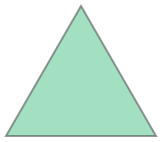

In [61]:
points.convex_hull

In [60]:
isec.area

0.0

In [49]:
for bound in mapoly.exterior:
    print(bound)
    break

AttributeError: 'LineString' object has no attribute 'exterior'

In [46]:
isec.lengthMultiPoint

75.0

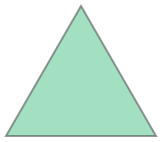

In [39]:
points.convex_hull

In [13]:
poly = Polygon([(-75, -65),(75, -65), (0, 65)])

for 


line = LineString([(-100, 0), (100, 0)])

isec = poly.intersection(line)

In [16]:
isec.length

75.0

In [6]:
tracks, track_records = generate_realistic_tracks(det, height, radius, 5000, seed=31337, propagator=prop, log_emin=1, log_emax=8, filter=False,
                                                 photocathode_area=16 * (7.62/2)**2 * np.pi * 1E-4,
                                                 lambda_abs=30, lambda_sca=100)

In [7]:
pickle.dump((tracks, track_records), open("pone_3str_tracks.pickle", "wb"))

In [5]:
tracks, track_records = pickle.load(open("pone_3str_tracks.pickle", "rb"))

In [ ]:
np.argwhere(~trigger_mask).squeeze()

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:180: RuntimeWarning:

divide by zero encountered in log10



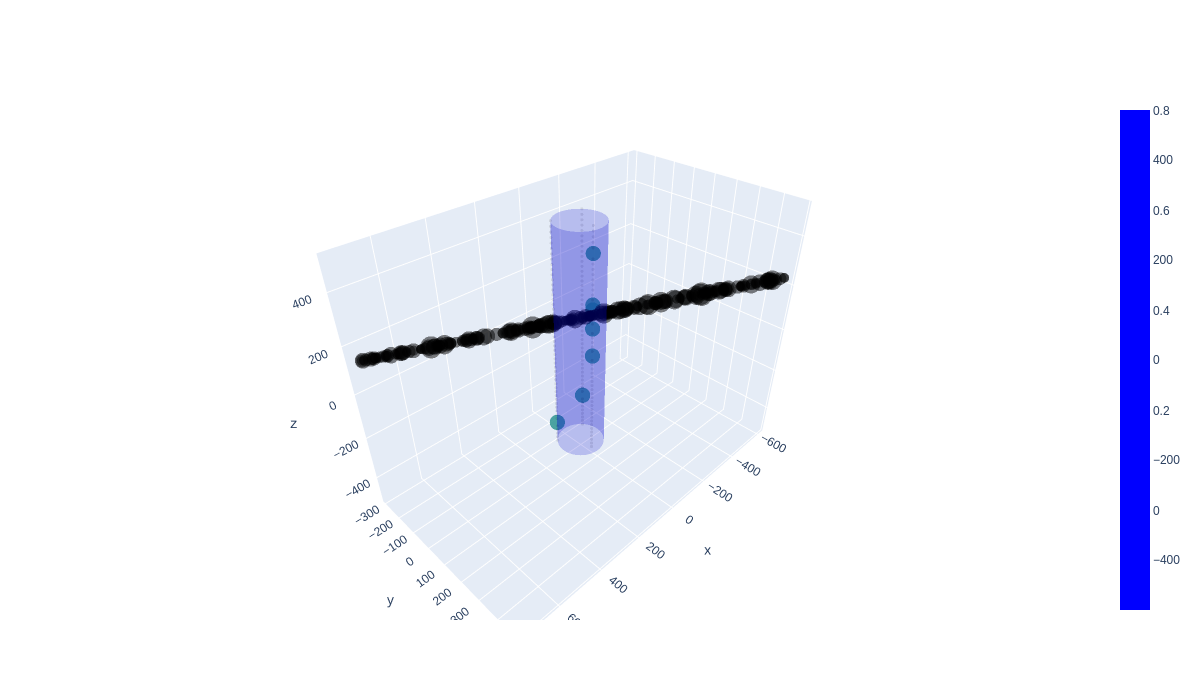

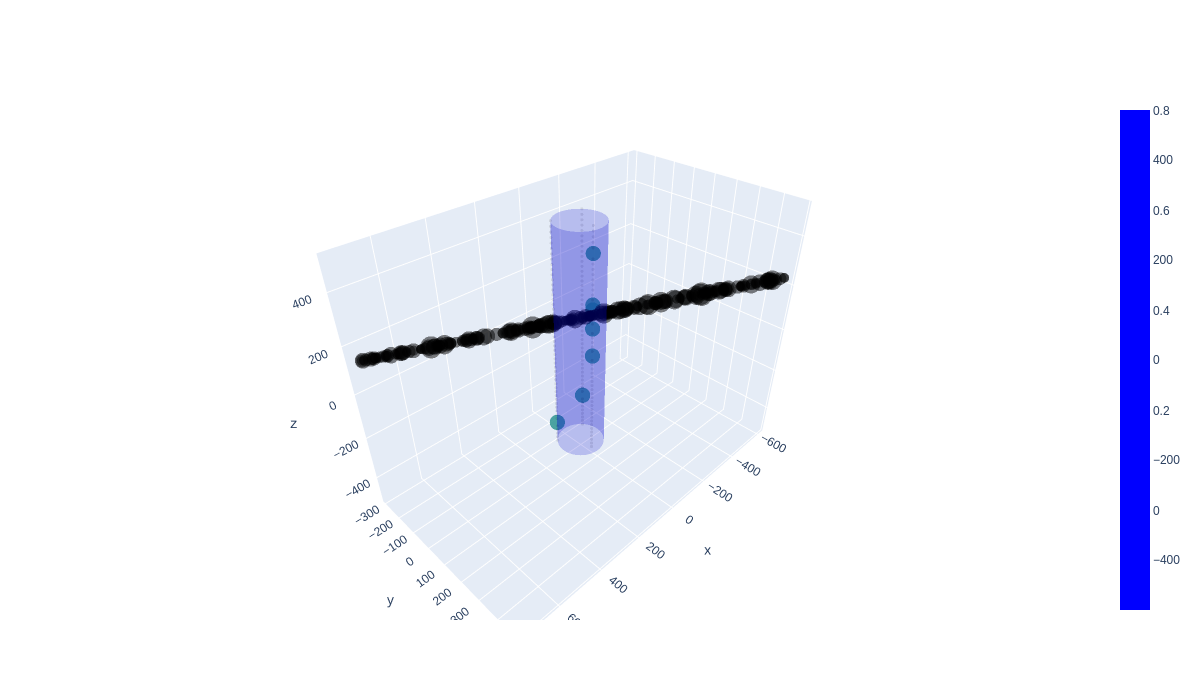

In [195]:
plot_event(det, tracks[3], track_records[3], plot_hull=True)

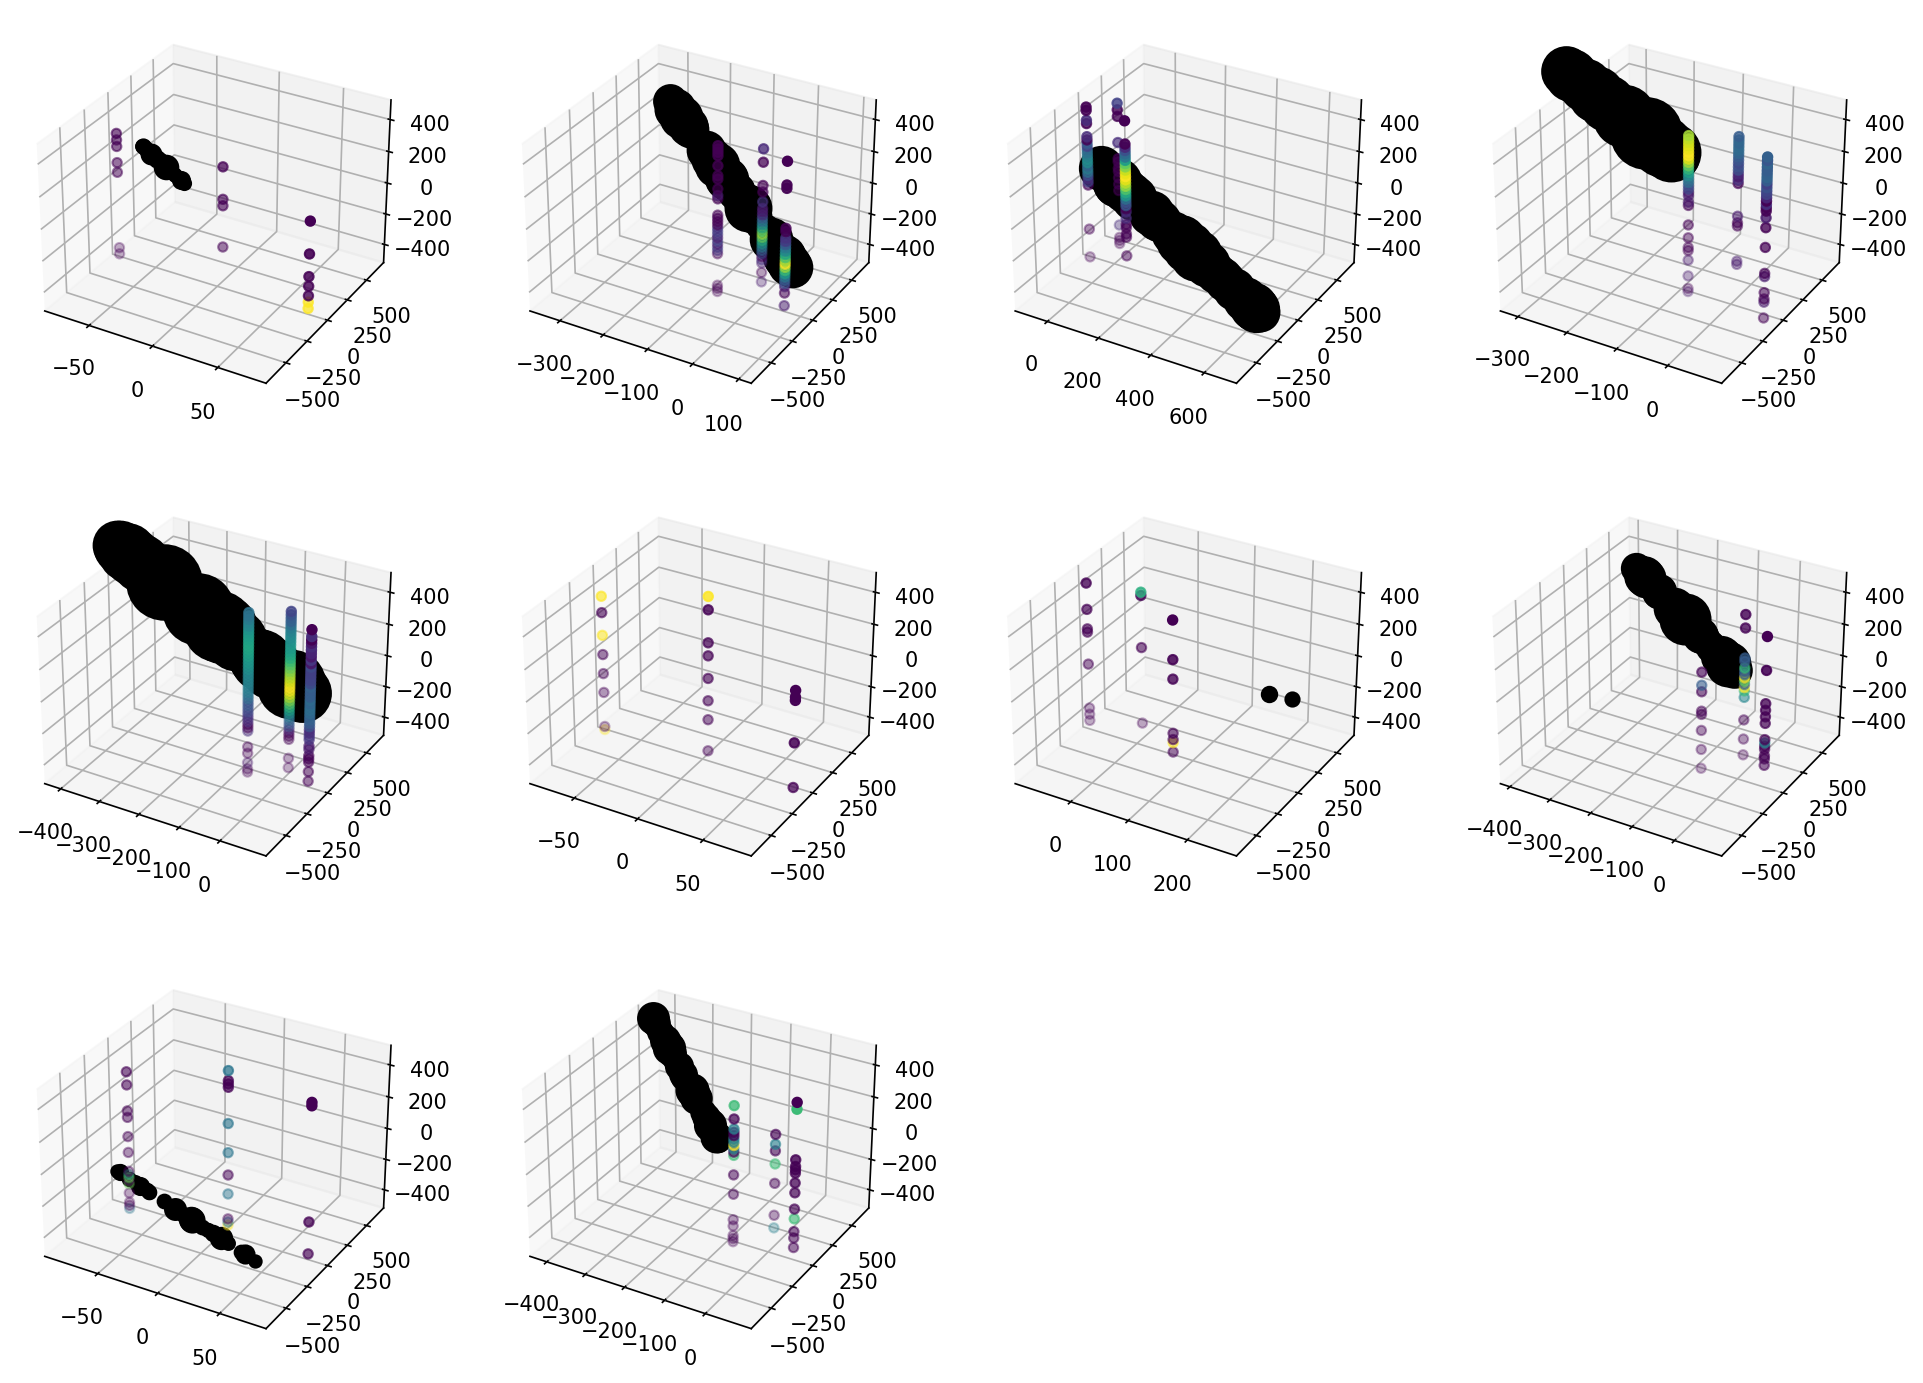

In [15]:
plot_events(det, tracks[10:20], records=track_records[10:20], );

In [8]:
proj_area_int = scipy.integrate.quad(lambda ct: get_proj_area_for_zen(height, radius, ct), -1, 1)[0] / (2)
proj_area_det_int = scipy.integrate.quad(lambda ct: get_proj_area_for_zen(1000, 150, ct), -1, 1)[0] / (2)

In [9]:
triggers = []
for event in tracks:
    triggers.append(trigger(det, event, mod_thresh=3, phot_thres=3))
    
triggers_low = []
for event in tracks:
    triggers_low.append(trigger(det, event, mod_thresh=1, phot_thres=5))

In [10]:
track_records[0].mc_info[0]

{'position': array([ -26.16245443,  122.23144431, -232.04602429]),
 'energy': array([158.27910548]),
 'track_len': 650.173737294042,
 'direction': array([ 0.95908486, -0.11928145, -0.25676483])}

[]

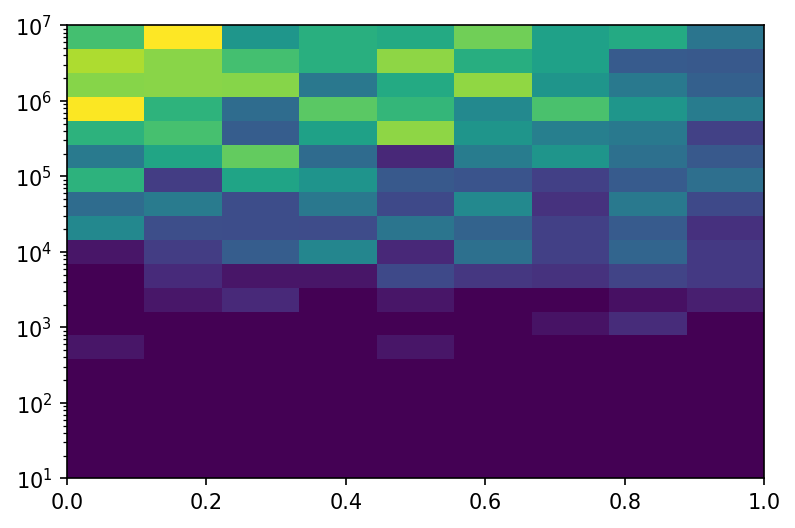

In [27]:
trigger_mask = np.asarray(triggers_low)

energies = np.asarray([tr.mc_info[0]["energy"][0] for tr in track_records])
coszeniths = np.cos([get_zen_azi(tr.mc_info[0]["direction"])[0] for tr in track_records])

ebins = np.logspace(1, 7, 20)
costbins = np.linspace(0, 1, 10)
ctbinc = 0.5*(costbins[1:] + costbins[:-1])
thist, xedge, yedge = np.histogram2d(energies[trigger_mask], coszeniths[trigger_mask], bins=[ebins, costbins])
pints = np.asarray([
    scipy.integrate.quad(
        lambda ct: get_proj_area_for_zen(height, radius, ct),
        costbins[i], costbins[i+1])[0] / (costbins[i+1] - costbins[i])
    for i in range(len(costbins)-1)
])

thist = thist / len(tracks) * pints 

plt.pcolormesh(yedge, xedge, thist)
plt.semilogy()


Text(0, 0.5, 'Effective Area [m²]')

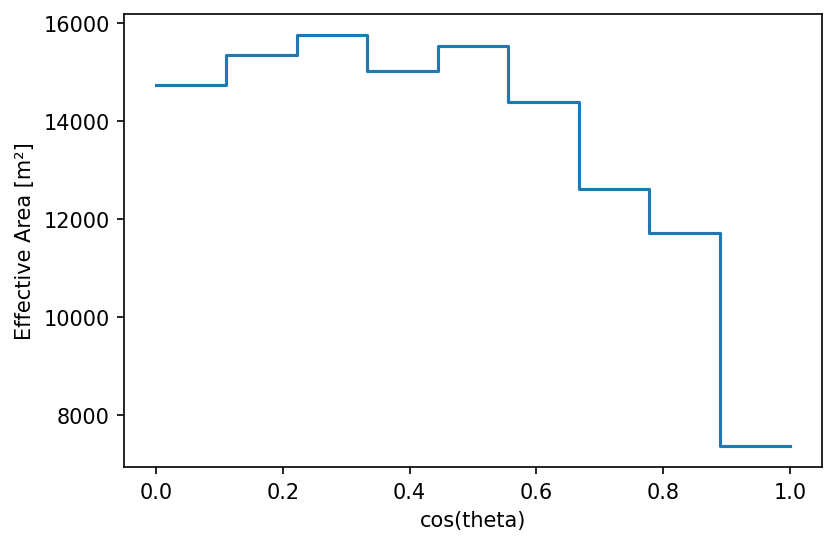

In [28]:
#hzen, _ = np.histogram(coszeniths[trigger_mask], bins=costbins)
hzen, _ = np.histogram(coszeniths, bins=costbins)
hzen = hzen * pints / len(tracks)

plt.step(costbins, np.append(hzen, hzen[-1]), where="post")
plt.xlabel("cos(theta)")
plt.ylabel("Effective Area [m²]")

Text(0, 0.5, 'Effective Area [m²]')

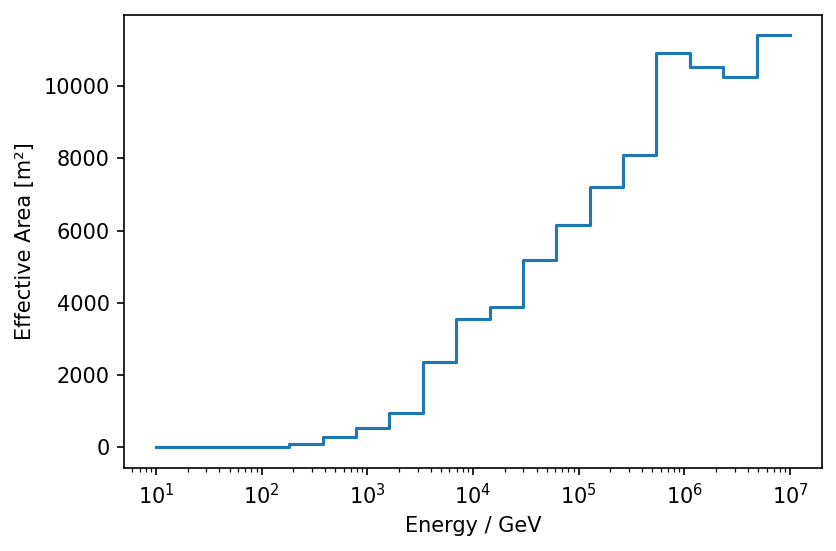

In [29]:
hzen, _ = np.histogram(energies[trigger_mask], bins=ebins)
#hzen, _ = np.histogram(coszeniths, bins=costbins)
hzen = hzen * proj_area_int / len(tracks)

plt.step(ebins, np.append(hzen, hzen[-1]), where="post")
plt.semilogx()
plt.xlabel("Energy / GeV")
plt.ylabel("Effective Area [m²]")

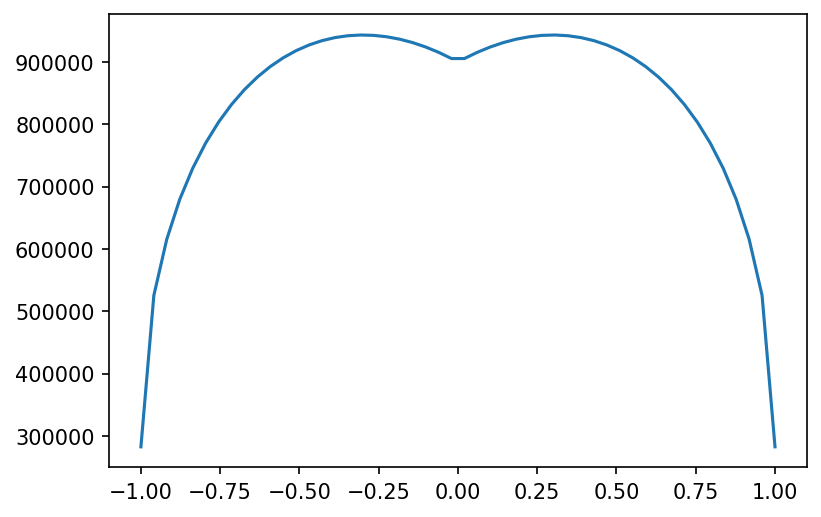

In [152]:
cz = np.linspace(-1, 1)
plt.plot(cz, get_proj_area_for_zen(1500, 300, cz))

In [13]:
np.cos(0)

1.0

In [ ]:
mceqconfig.debug_level = 2
mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model='SIBYLL2.3c',
#primary cosmic ray flux model
#support a tuple (primary model class (not instance!), arguments)
primary_model=(pm.GlobalSplineFitBeta, None),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=0.0
)


In [30]:
#import solver related modules
mceqconfig.e_min = 10.
mceqconfig.enable_default_tracking = False
mceqconfig.muon_helicity_dependence = False
mceqconfig.dXmax = 1.
mceqconfig.debug_level = 0


mceqconfig.max_density = 0.001225
mceq_surface = MCEqRun(
    interaction_model='SIBYLL23d',
    primary_model=(pm.GlobalSplineFitBeta, None),
    theta_deg=0,
)
from MCEq.geometry.density_profiles import GeneralizedTarget
# Create a homogeneous target material
target_water = GeneralizedTarget(len_target=2000e2) # 2km
density = 1.
target_water.add_material(0.,density,'Water')

#mceqconfig.adv_set["exclude_from_mixing"] = [13, -13]
mceqconfig.leading_process = 'auto'
mceqconfig.max_density = density
mceq_water = MCEqRun(
    interaction_model = 'SIBYLL23d', #This doesn't matter if you only propagate muons 
    primary_model = None,
    theta_deg = None,
    medium='water',
    particle_list=[(13,0),(-13,0)],
    density_model = target_water,
)

In [162]:
#Solve at the surface
mceq_surface.solve()

In [32]:
#Copy the state (muon fluxes only here but can be the entire stack of densities)
mceq_water._set_state_vector(*mceq_surface._get_state_vector(), only_available=True)
depths = np.arange(10., 2000.1 , 10)*100 #read out at steps of 10 meters
#Solve in water
mceq_water.solve(int_grid=depths)

Text(0, 0.5, 'Vertical muon intensity (g cm$^2$ sr)$^{-1}$')

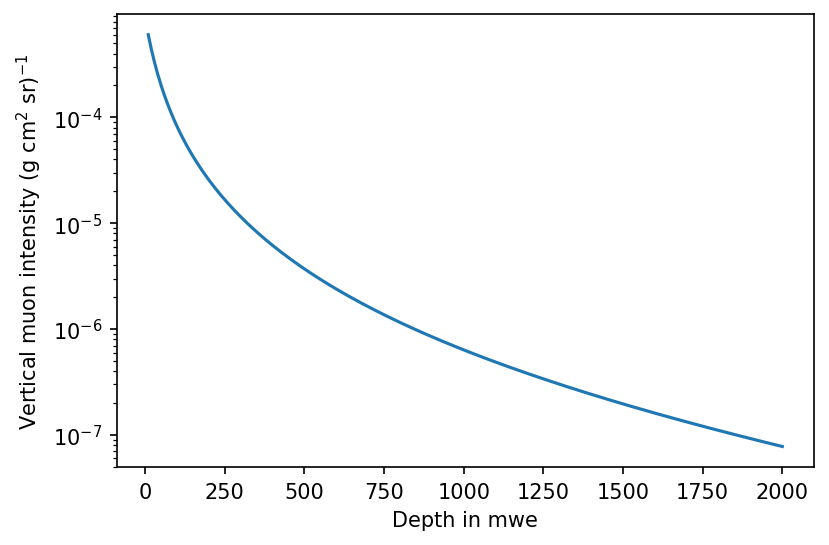

In [164]:
plt.semilogy(depths/1e2, np.sum([mceq_water.get_solution('mu+', integrate=True, grid_idx=i)
                             + mceq_water.get_solution('mu-', integrate=True, grid_idx=i)
                            for i in range(len(depths))], axis=1))
plt.xlabel('Depth in mwe')
plt.ylabel(r'Vertical muon intensity (g cm$^2$ sr)$^{-1}$')


MCEqRun::solve(): Launching euler solver
MCEqRun::solve(): for 125000 integration steps.
solv_numpy(): Performance:   0.11ms/iteration
MCEqRun::solve(): time elapsed during integration: 13.84sec


[]

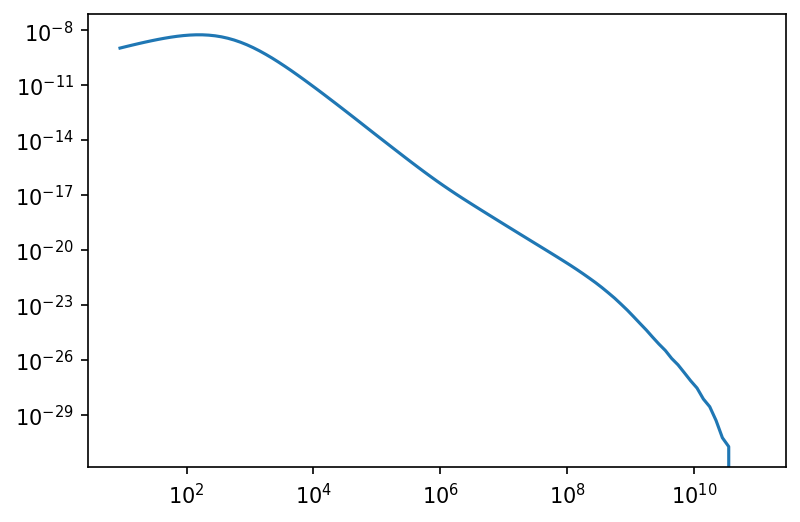

In [165]:
flux = mceq_water.get_solution('total_mu+', 0, integrate=True) + \
    mceq_water.get_solution('total_mu-', 0, integrate=True)
plt.plot(mceq_water.e_grid, flux)
plt.loglog()

In [33]:
mup_dict, numu_dict, nue_dict = {}, {}, {}

cost_steps_mceq = np.linspace(0.3, 1, 10)


for ctheta in cost_steps_mceq:
    mceq_surface.set_theta_deg(np.degrees(np.arccos(ctheta)))
    mceq_surface.solve()
    mceq_water._set_state_vector(*mceq_surface._get_state_vector(), only_available=True)
    
    target_water.set_length(2000 / ctheta * 100)
    mceq_water._calculate_integration_path(int_grid=depths, grid_var='X', force=True)
    
    mceq_water.solve()

    mag = 0

    mup_dict[ctheta] = mceq_water.get_solution('total_mu+', mag, integrate=True) + \
                           mceq_water.get_solution('total_mu-', mag, integrate=True)


(1e-20, 1e-08)

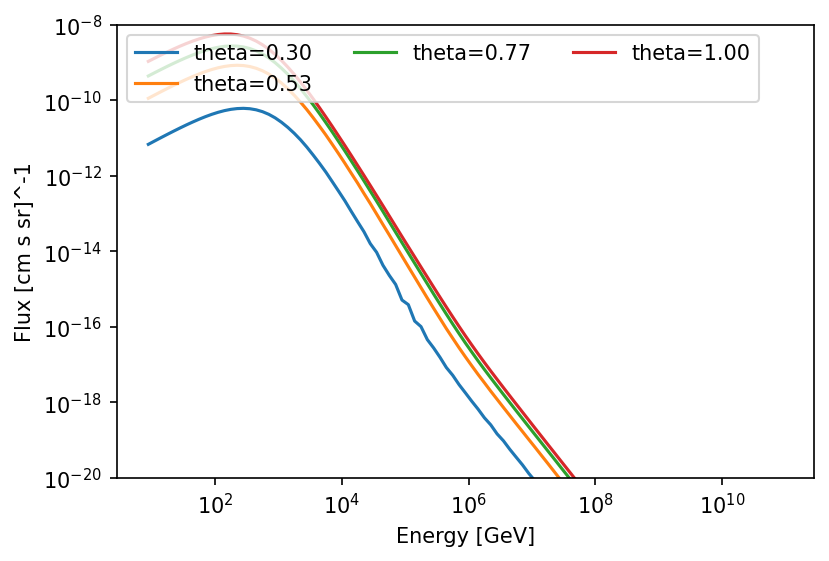

In [35]:
e_grid = mceq_water.e_grid

for theta in list(mup_dict.keys())[::3]:
    plt.plot(e_grid, mup_dict[theta], label=f"theta={theta:.2f}")
plt.loglog()
plt.legend(loc="upper left", ncol=3)
plt.ylabel("Flux [cm s sr]^-1")
plt.xlabel("Energy [GeV]")
plt.ylim(1E-20, 1E-8)

In [130]:
np.diff(cost_steps_mceq[i:i+2])

array([], dtype=float64)

(1e-09, 0.1)

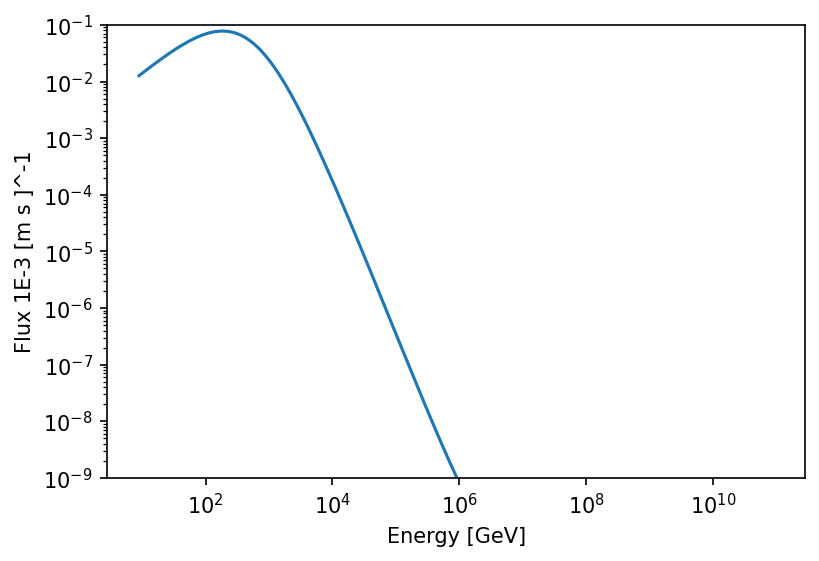

In [168]:
e_grid = mceq_water.e_grid

tot_fl = 0

for i, theta in enumerate(cost_steps_mceq[:-1]):
    tot_fl = tot_fl + mup_dict[theta] * 2*np.pi * np.diff(cost_steps_mceq[i:i+2]) * 1E4 * 1E3
    
    
plt.plot(e_grid, tot_fl)
plt.loglog()
plt.ylabel("Flux 1E-3 [m s ]^-1")
plt.xlabel("Energy [GeV]")
plt.ylim(1E-9, 1E-1)

/tmp/ipykernel_846/2715615815.py:6: RuntimeWarning: invalid value encountered in log10
  log_mup_grid = np.log10(mup_grid)
/tmp/ipykernel_846/2715615815.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(np.log10(e_grid), cost_steps_mceq, log_mup_grid.T)
/tmp/ipykernel_846/2715615815.py:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xeval, yeval, log10_muon_flux)


Text(0.5, 0, 'log10(E)')

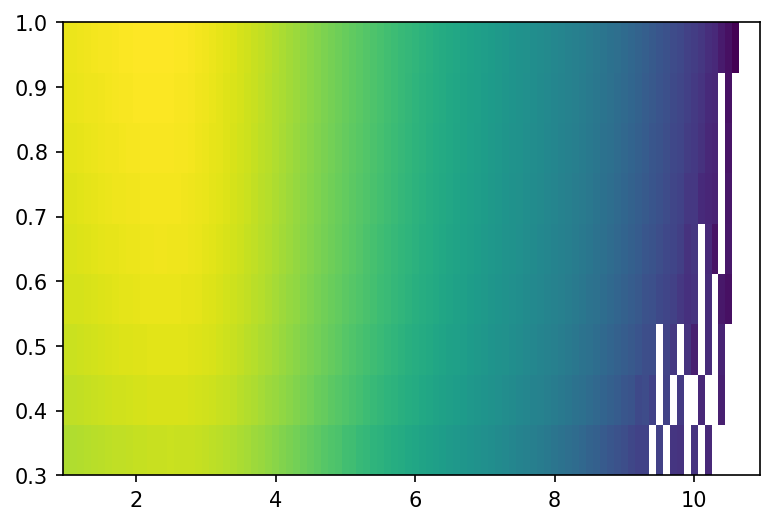

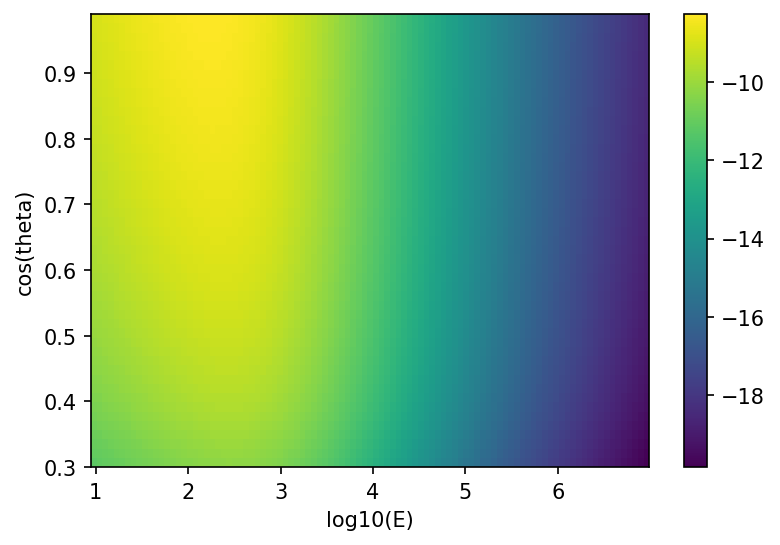

In [36]:
from scipy.interpolate import griddata
mup_grid = np.empty((e_grid.shape[0], len(mup_dict)))
for i, ct in enumerate(mup_dict.keys()):
    mup_grid[:, i] = mup_dict[ct]

log_mup_grid = np.log10(mup_grid)
mask = np.isfinite(log_mup_grid)



plt.pcolormesh(np.log10(e_grid), cost_steps_mceq, log_mup_grid.T)
plt.figure()

valid_idx = np.argwhere(mask)

px = np.log10(e_grid[valid_idx[:, 0]])
py = cost_steps_mceq[valid_idx[:, 1]]

xeval = np.linspace(np.log10(e_grid.min()), 6.99, 100)
yeval = np.linspace(cost_steps_mceq.min(), 0.99, 50)

X, Y = np.meshgrid(xeval, yeval)

log10_muon_flux = griddata((px, py), log_mup_grid[mask], (X, Y), method="cubic")


plt.pcolormesh(xeval, yeval, log10_muon_flux)
plt.colorbar()
plt.ylabel("cos(theta)")
plt.xlabel("log10(E)")


In [37]:
rates = []

flux = 10**log10_muon_flux

for i, e in enumerate(xeval):
    rate = []
    for j, ct in enumerate(yeval[:-1]):
       
        aeff_bin = np.digitize(10**e, ebins)-1
        ctbin = np.digitize(ct, costbins)-1
        
        area = thist[aeff_bin, ctbin] * 1E4 # cm²
        sangle = 2*np.pi * np.diff(yeval[j:j+2])
        rate.append((area * flux[j, i] * sangle))

    rates.append(np.sum(rate))
    

(2.5, 7)

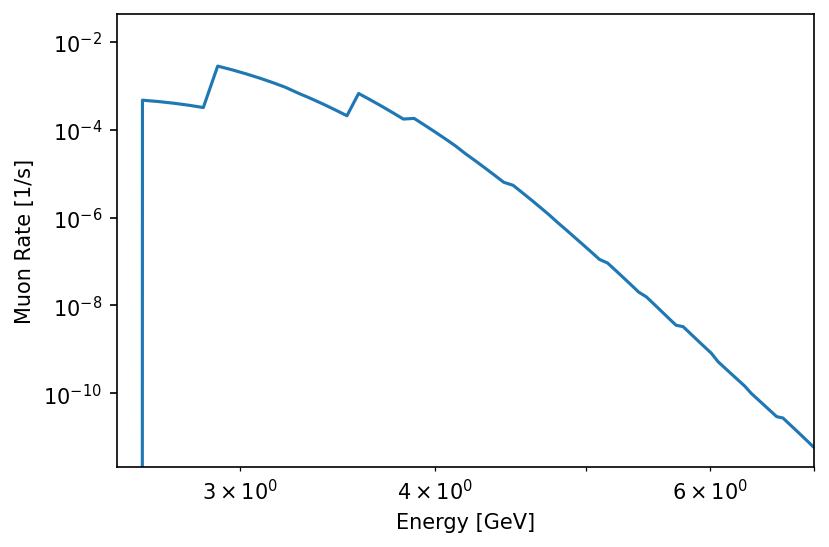

In [40]:
plt.plot(xeval, np.asarray(rates)*2) #FUDGE BECAUSE 4pi INJECTTION
plt.loglog()
#plt.xlim(1E2, 1E7)
#plt.ylim(1E-4, 1E3)
plt.xlabel("Energy [GeV]")
plt.ylabel("Muon Rate [1/s]")
plt.xlim(2.5, 7)
#plt.ylim(1E-3, 1E-1)

In [44]:
np.sum(rates[:-1] * np.diff(xeval))

0.000955217934950089